In [1]:
# imports
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

C:\Users\sunny\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\sunny\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
to_drop=['Interest_rate_spread','rate_of_interest','Upfront_charges'] 
# dropping columns with due to limitation of data availibility based on EDA 

In [3]:
df=pd.read_csv('data/cleaned.csv',index_col=0)
y=df['Status']
df=df.drop(columns=['Status'])
features=df.drop(columns=to_drop)
numeric=['int64','float64']
baseline_num_features=features.select_dtypes(include=numeric)

In [4]:
baseline_num_features

,loan_amount,term,property_value,income,Credit_Score,LTV,dtir1
0,116500,360.0,118000.0,1740.0,758,98.728814,45.0
2,406500,360.0,508000.0,9480.0,834,80.019685,46.0
3,456500,360.0,658000.0,11880.0,587,69.376900,42.0
4,696500,360.0,758000.0,10440.0,602,91.886544,39.0
5,706500,360.0,1008000.0,10080.0,864,70.089286,40.0
...,...,...,...,...,...,...,...
148665,436500,180.0,608000.0,7860.0,659,71.792763,48.0
148666,586500,360.0,788000.0,7140.0,569,74.428934,15.0
148667,446500,180.0,728000.0,6900.0,702,61.332418,49.0
148668,196500,180.0,278000.0,7140.0,737,70.683453,29.0


In [5]:
features.columns

Index(['loan_limit', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'Credit_Worthiness', 'open_credit', 'business_or_commercial',
       'loan_amount', 'term', 'Neg_ammortization', 'interest_only',
       'lump_sum_payment', 'property_value', 'occupancy_type', 'total_units',
       'income', 'Credit_Score', 'age', 'submission_of_application', 'LTV',
       'Region', 'dtir1'],
      dtype='object')

In [6]:
baseline_cat_features=['business_or_commercial','Neg_ammortization','lump_sum_payment','interest_only']
bl_cat_features=features[baseline_cat_features]
bl_cat_features

,business_or_commercial,Neg_ammortization,lump_sum_payment,interest_only
0,nob/c,not_neg,not_lpsm,not_int
2,nob/c,neg_amm,not_lpsm,not_int
3,nob/c,not_neg,not_lpsm,not_int
4,nob/c,not_neg,not_lpsm,not_int
5,nob/c,not_neg,not_lpsm,not_int
...,...,...,...,...
148665,nob/c,not_neg,not_lpsm,not_int
148666,nob/c,not_neg,not_lpsm,not_int
148667,nob/c,not_neg,not_lpsm,not_int
148668,nob/c,not_neg,not_lpsm,not_int


In [7]:
ohc = OneHotEncoder(drop = 'first',sparse=False)
ohc.fit_transform(bl_cat_features)

array([[1., 1., 1., 1.],
       [1., 0., 1., 1.],
       [1., 1., 1., 1.],
       ...,
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [8]:
ohc.get_feature_names()

array(['x0_nob/c', 'x1_not_neg', 'x2_not_lpsm', 'x3_not_int'],
      dtype=object)

In [9]:
bl_ohc_features=pd.DataFrame(ohc.fit_transform(bl_cat_features),columns=ohc.get_feature_names(),index=bl_cat_features.index)
bl_ohc_features

,x0_nob/c,x1_not_neg,x2_not_lpsm,x3_not_int
0,1.0,1.0,1.0,1.0
2,1.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0
...,...,...,...,...
148665,1.0,1.0,1.0,1.0
148666,1.0,1.0,1.0,1.0
148667,1.0,1.0,1.0,1.0
148668,1.0,1.0,1.0,1.0


In [10]:
X=pd.concat([baseline_num_features,bl_ohc_features],axis=1)
X

,loan_amount,term,property_value,income,Credit_Score,LTV,dtir1,x0_nob/c,x1_not_neg,x2_not_lpsm,x3_not_int
0,116500,360.0,118000.0,1740.0,758,98.728814,45.0,1.0,1.0,1.0,1.0
2,406500,360.0,508000.0,9480.0,834,80.019685,46.0,1.0,0.0,1.0,1.0
3,456500,360.0,658000.0,11880.0,587,69.376900,42.0,1.0,1.0,1.0,1.0
4,696500,360.0,758000.0,10440.0,602,91.886544,39.0,1.0,1.0,1.0,1.0
5,706500,360.0,1008000.0,10080.0,864,70.089286,40.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
148665,436500,180.0,608000.0,7860.0,659,71.792763,48.0,1.0,1.0,1.0,1.0
148666,586500,360.0,788000.0,7140.0,569,74.428934,15.0,1.0,1.0,1.0,1.0
148667,446500,180.0,728000.0,6900.0,702,61.332418,49.0,1.0,1.0,1.0,1.0
148668,196500,180.0,278000.0,7140.0,737,70.683453,29.0,1.0,1.0,1.0,1.0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)
X_train.shape, X_test.shape

((84368, 11), (36158, 11))

In [12]:
num_features_list=['loan_amount','term','property_value','income','Credit_Score','LTV','dtir1']
cat_features_list=['x0_nob/c','x1_not_neg','x2_not_lpsm','x3_not_int']
X_train_num=X_train[num_features_list]
X_test_num=X_test[num_features_list]
sc=StandardScaler()
X_train_num_sc=sc.fit_transform(X_train_num)
X_test_num_sc=sc.transform(X_test_num)

In [13]:
X_train_num_sc

array([[ 0.80505868,  0.4396436 ,  0.55248121, ..., -0.59260334,
        -0.2238071 ,  0.68751841],
       [ 0.53184194,  0.4396436 , -0.06864887, ...,  1.5278651 ,
         0.93811458,  0.68751841],
       [ 1.18756213,  0.4396436 ,  0.55248121, ...,  0.84690166,
         0.30018912, -0.16567932],
       ...,
       [-1.21674523, -2.56029314,  1.038583  , ..., -1.36838447,
        -3.15510064, -2.25127377],
       [ 0.80505868,  0.4396436 ,  0.79553211, ...,  0.06250073,
        -0.62609099, -1.58767554],
       [-0.83424179,  0.4396436 , -0.55475067, ...,  1.51062552,
        -0.6517206 , -3.1044715 ]])

In [14]:
X_train_num_sc=pd.DataFrame(X_train_num_sc,columns=X_train_num.columns,index=X_train_num.index)
X_train_sc=pd.concat([X_train_num_sc,X_train[cat_features_list]],axis=1)
X_test_num_sc=pd.DataFrame(X_test_num_sc,columns=X_test_num.columns,index=X_test_num.index)
X_test_sc=pd.concat([X_test_num_sc,X_test[cat_features_list]],axis=1)

In [15]:
X_test_sc

,loan_amount,term,property_value,income,Credit_Score,LTV,dtir1,x0_nob/c,x1_not_neg,x2_not_lpsm,x3_not_int
67115,-0.451738,0.439644,0.012368,-0.145605,1.269271,-1.219046,-1.872075,1.0,1.0,1.0,1.0
75261,-0.888885,0.439644,-0.878819,-0.587999,1.717500,1.166717,-0.070880,1.0,0.0,1.0,1.0
60397,-0.561025,-0.160344,-0.527745,-0.537727,1.148594,0.106729,0.592719,1.0,0.0,1.0,1.0
24636,-0.888885,0.439644,-0.770796,0.588369,-0.713280,0.257095,-0.070880,1.0,1.0,1.0,1.0
143126,-1.489962,0.439644,-1.148875,-0.678489,0.648646,0.048268,-0.165679,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
10600,-0.451738,0.439644,-0.635768,-0.014897,-0.239192,1.083949,2.014715,0.0,1.0,1.0,1.0
63493,0.750415,0.439644,0.444459,0.337008,-1.377004,-0.089558,0.213520,1.0,0.0,1.0,1.0
116294,-0.397095,0.439644,-0.176671,-0.537727,-0.790859,-0.687046,0.592719,1.0,1.0,1.0,0.0
103494,-0.342452,0.439644,-0.608762,-0.648326,-1.532160,1.289885,0.877118,0.0,1.0,1.0,1.0


# Baseline model - Logistic Regression with basic set of features: 
Loan Amount, Term, Income, Property Value, Credit Score, LRV, DTIR, Business/Commercial, Negative amortization, Lump-sum payment, Interest-only

In [16]:
lr=LogisticRegression(random_state=42)

In [17]:
lr.fit(X_train_sc,y_train)
y_train_pred=lr.predict(X_train_sc)

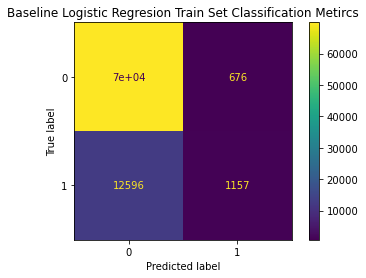

              precision    recall  f1-score   support

           0       0.85      0.99      0.91     70615
           1       0.63      0.08      0.15     13753

    accuracy                           0.84     84368
   macro avg       0.74      0.54      0.53     84368
weighted avg       0.81      0.84      0.79     84368



In [18]:
plot_confusion_matrix(lr,X_train_sc,y_train)
plt.title('Baseline Logistic Regresion Train Set Classification Metircs')
plt.show()
print(classification_report(y_train,lr.predict(X_train_sc)))

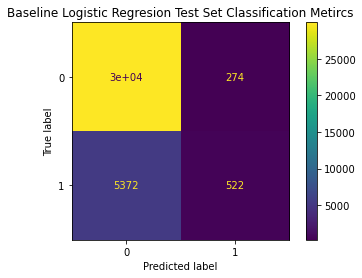

              precision    recall  f1-score   support

           0       0.85      0.99      0.91     30264
           1       0.66      0.09      0.16      5894

    accuracy                           0.84     36158
   macro avg       0.75      0.54      0.54     36158
weighted avg       0.82      0.84      0.79     36158



In [19]:
plot_confusion_matrix(lr,X_test_sc,y_test)
plt.title('Baseline Logistic Regresion Test Set Classification Metircs')
plt.show()
print(classification_report(y_test,lr.predict(X_test_sc)))

Scrores demonstrates class imbalance issues, tuning model with balanced class weights

## LR1 - balanced class weights

In [20]:
lr1=LogisticRegression(C=1,random_state=42,class_weight='balanced')
lr1.fit(X_train_sc,y_train)
y_train_pred=lr1.predict(X_train_sc)
y_test_pred=lr1.predict(X_test_sc)

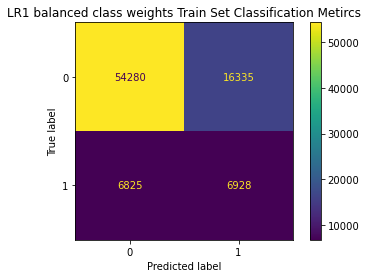

              precision    recall  f1-score   support

           0       0.89      0.77      0.82     70615
           1       0.30      0.50      0.37     13753

    accuracy                           0.73     84368
   macro avg       0.59      0.64      0.60     84368
weighted avg       0.79      0.73      0.75     84368



In [21]:
plot_confusion_matrix(lr1,X_train_sc,y_train)
plt.title('LR1 balanced class weights Train Set Classification Metircs')
plt.show()
print(classification_report(y_train,lr1.predict(X_train_sc)))

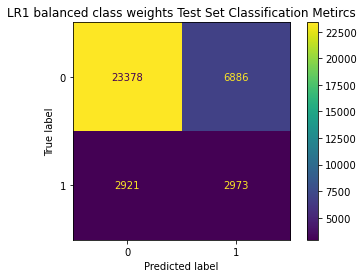

              precision    recall  f1-score   support

           0       0.89      0.77      0.83     30264
           1       0.30      0.50      0.38      5894

    accuracy                           0.73     36158
   macro avg       0.60      0.64      0.60     36158
weighted avg       0.79      0.73      0.75     36158



In [22]:
plot_confusion_matrix(lr1,X_test_sc,y_test)
plt.title('LR1 balanced class weights Test Set Classification Metircs')
plt.show()
print(classification_report(y_test,lr1.predict(X_test_sc)))

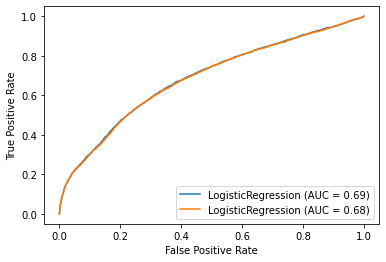

In [23]:
f, ax=plt.subplots()
plot_roc_curve(lr,X_test_sc,y_test,ax=ax)
plot_roc_curve(lr1,X_test_sc,y_test,ax=ax)

## LR2 - Using SMOTE Strategy

In [24]:
print(y.value_counts(normalize=True))
print(f'current ratio: {y.value_counts()[1]/y.value_counts()[0]}')

0    0.83699
1    0.16301
Name: Status, dtype: float64
current ratio: 0.19475807650749907


In [25]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(sampling_strategy=1)
X_train_resam,y_train_resam=smote.fit_resample(X_train_sc,y_train)

In [26]:
y_train.value_counts(normalize=True)

0    0.836988
1    0.163012
Name: Status, dtype: float64

In [27]:
y_train_resam.value_counts(normalize=True)

0    0.5
1    0.5
Name: Status, dtype: float64

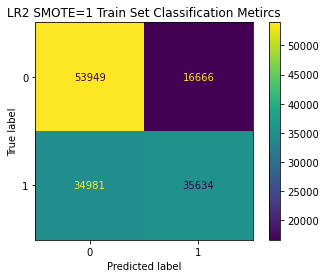

              precision    recall  f1-score   support

           0       0.61      0.76      0.68     70615
           1       0.68      0.50      0.58     70615

    accuracy                           0.63    141230
   macro avg       0.64      0.63      0.63    141230
weighted avg       0.64      0.63      0.63    141230



In [28]:
lr2=LogisticRegression(C=1,random_state=42)
lr2.fit(X_train_resam,y_train_resam)
plot_confusion_matrix(lr2,X_train_resam,y_train_resam)
plt.title('LR2 SMOTE=1 Train Set Classification Metircs')
plt.show()
print(classification_report(y_train_resam,lr2.predict(X_train_resam)))

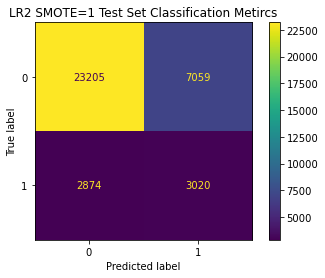

              precision    recall  f1-score   support

           0       0.89      0.77      0.82     30264
           1       0.30      0.51      0.38      5894

    accuracy                           0.73     36158
   macro avg       0.59      0.64      0.60     36158
weighted avg       0.79      0.73      0.75     36158



In [29]:
plot_confusion_matrix(lr2,X_test_sc,y_test)
plt.title('LR2 SMOTE=1 Test Set Classification Metircs')
plt.show()
print(classification_report(y_test,lr2.predict(X_test_sc)))

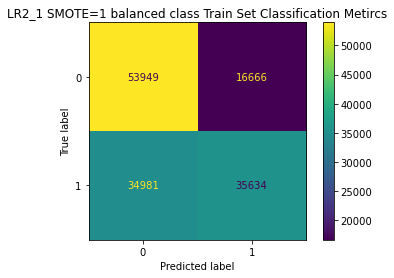

              precision    recall  f1-score   support

           0       0.61      0.76      0.68     70615
           1       0.68      0.50      0.58     70615

    accuracy                           0.63    141230
   macro avg       0.64      0.63      0.63    141230
weighted avg       0.64      0.63      0.63    141230



In [30]:
lr2_1=LogisticRegression(C=1,random_state=42,class_weight='balanced')
lr2_1.fit(X_train_resam,y_train_resam)
plot_confusion_matrix(lr2_1,X_train_resam,y_train_resam)
plt.title('LR2_1 SMOTE=1 balanced class Train Set Classification Metircs')
plt.show()
print(classification_report(y_train_resam,lr2_1.predict(X_train_resam)))

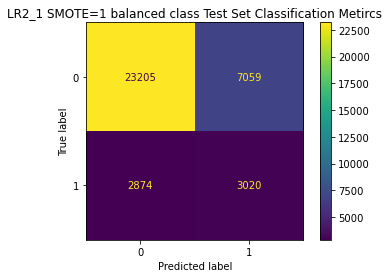

              precision    recall  f1-score   support

           0       0.89      0.77      0.82     30264
           1       0.30      0.51      0.38      5894

    accuracy                           0.73     36158
   macro avg       0.59      0.64      0.60     36158
weighted avg       0.79      0.73      0.75     36158



In [31]:
plot_confusion_matrix(lr2_1,X_test_sc,y_test)
plt.title('LR2_1 SMOTE=1 balanced class Test Set Classification Metircs')
plt.show()
print(classification_report(y_test,lr2_1.predict(X_test_sc)))

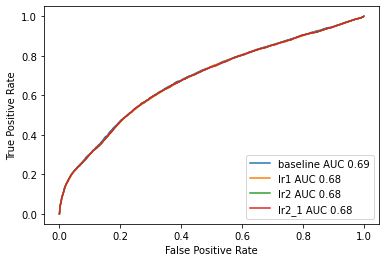

In [32]:
f, ax=plt.subplots()
plot_roc_curve(lr,X_test_sc,y_test,ax=ax,label=f"baseline AUC {roc_auc_score(y_test,lr.predict_proba(X_test_sc)[:,1]):.2f}")
plot_roc_curve(lr1,X_test_sc,y_test,ax=ax,label=f"lr1 AUC {roc_auc_score(y_test,lr1.predict_proba(X_test_sc)[:,1]):.2f}")
plot_roc_curve(lr2,X_test_sc,y_test,ax=ax,label=f"lr2 AUC {roc_auc_score(y_test,lr2.predict_proba(X_test_sc)[:,1]):.2f}")
plot_roc_curve(lr2_1,X_test_sc,y_test,ax=ax,label=f"lr2_1 AUC {roc_auc_score(y_test,lr2_1.predict_proba(X_test_sc)[:,1]):.2f}")

ratio 0.20 recall score 0.09 accuray score 0.84  f1 score 0.16
ratio 0.30 recall score 0.12 accuray score 0.84  f1 score 0.20
ratio 0.40 recall score 0.17 accuray score 0.84  f1 score 0.26
ratio 0.50 recall score 0.24 accuray score 0.82  f1 score 0.31
ratio 0.60 recall score 0.32 accuray score 0.80  f1 score 0.34
ratio 0.70 recall score 0.37 accuray score 0.78  f1 score 0.35
ratio 0.80 recall score 0.41 accuray score 0.76  f1 score 0.36
ratio 0.90 recall score 0.46 accuray score 0.75  f1 score 0.37
ratio 1.00 recall score 0.51 accuray score 0.73  f1 score 0.38


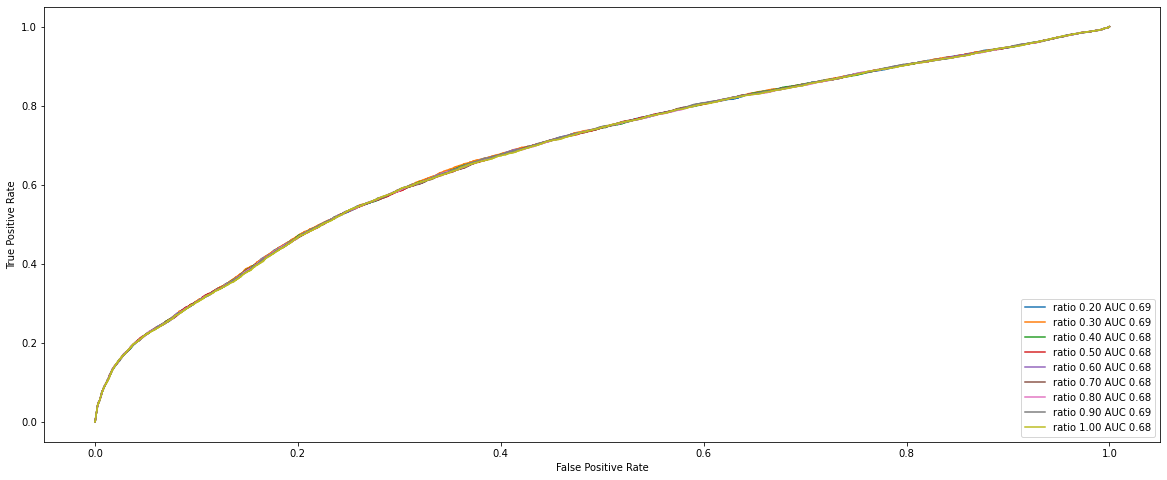

In [33]:
#trying out different SMOTE strategy for LR2, best recall score is equal sampling
f, ax=plt.subplots(figsize=(20,8))
for ratio in np.linspace(0.2,1,9):
    smote=SMOTE(sampling_strategy=ratio)
    X_train_resam,y_train_resam=smote.fit_resample(X_train_sc,y_train)
    lr2_2=LogisticRegression(C=1,random_state=42)
    lr2_2.fit(X_train_resam,y_train_resam)
    plot_roc_curve(lr2_2,X_test_sc,y_test,ax=ax,label=f"ratio {ratio:.2f} AUC {roc_auc_score(y_test,lr2_2.predict_proba(X_test_sc)[:,1]):.2f}")
    print(f"ratio {ratio:.2f} recall score {recall_score(y_test,lr2_2.predict(X_test_sc)):.2f} accuray score {accuracy_score(y_test,lr2_2.predict(X_test_sc)):.2f}  f1 score {f1_score(y_test,lr2_2.predict(X_test_sc)):.2f}")

## LR3 SMOTE and More Catagorical Features

In [34]:
add_cat_features=['loan_limit','approv_in_adv','loan_type','loan_purpose','Credit_Worthiness','open_credit','occupancy_type','total_units','age','Region']
add_features=features[add_cat_features]
ohc_1 = OneHotEncoder(drop = 'first',sparse=False)
add_ohc_features=pd.DataFrame(ohc_1.fit_transform(add_features),columns=ohc_1.get_feature_names(),index=add_features.index)

In [35]:
X0=pd.concat([X,add_ohc_features],axis=1)
X0

,loan_amount,term,property_value,income,Credit_Score,LTV,dtir1,x0_nob/c,x1_not_neg,x2_not_lpsm,...,x7_4U,x8_35-44,x8_45-54,x8_55-64,x8_65-74,x8_<25,x8_>74,x9_North-East,x9_central,x9_south
0,116500,360.0,118000.0,1740.0,758,98.728814,45.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,406500,360.0,508000.0,9480.0,834,80.019685,46.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,456500,360.0,658000.0,11880.0,587,69.376900,42.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,696500,360.0,758000.0,10440.0,602,91.886544,39.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,706500,360.0,1008000.0,10080.0,864,70.089286,40.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,436500,180.0,608000.0,7860.0,659,71.792763,48.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
148666,586500,360.0,788000.0,7140.0,569,74.428934,15.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
148667,446500,180.0,728000.0,6900.0,702,61.332418,49.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148668,196500,180.0,278000.0,7140.0,737,70.683453,29.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y, test_size=0.3, random_state=42,stratify=y)
X0_train.shape, X0_test.shape

((84368, 34), (36158, 34))

In [37]:
new_cat_features_list=cat_features_list+list(ohc_1.get_feature_names())
X0_train_num=X0_train[num_features_list]
X0_test_num=X0_test[num_features_list]
sc0=StandardScaler()
X0_train_num_sc=sc0.fit_transform(X0_train_num)
X0_test_num_sc=sc0.transform(X0_test_num)
X0_train_num_sc=pd.DataFrame(X0_train_num_sc,columns=X0_train_num.columns,index=X0_train_num.index)
X0_train_sc=pd.concat([X0_train_num_sc,X0_train[new_cat_features_list]],axis=1)
X0_test_num_sc=pd.DataFrame(X0_test_num_sc,columns=X0_test_num.columns,index=X0_test_num.index)
X0_test_sc=pd.concat([X0_test_num_sc,X0_test[new_cat_features_list]],axis=1)

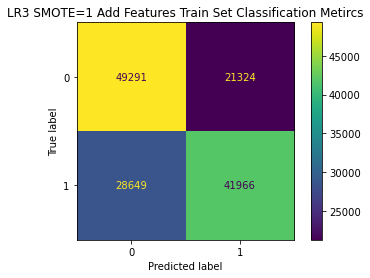

              precision    recall  f1-score   support

           0       0.63      0.70      0.66     70615
           1       0.66      0.59      0.63     70615

    accuracy                           0.65    141230
   macro avg       0.65      0.65      0.65    141230
weighted avg       0.65      0.65      0.65    141230



In [38]:
smote0=SMOTE(sampling_strategy=1)
X0_train_resam,y0_train_resam=smote.fit_resample(X0_train_sc,y0_train)
lr3=LogisticRegression(C=1,random_state=42)
lr3.fit(X0_train_resam,y0_train_resam)
plot_confusion_matrix(lr3,X0_train_resam,y0_train_resam)
plt.title('LR3 SMOTE=1 Add Features Train Set Classification Metircs')
plt.show()
print(classification_report(y0_train_resam,lr3.predict(X0_train_resam)))

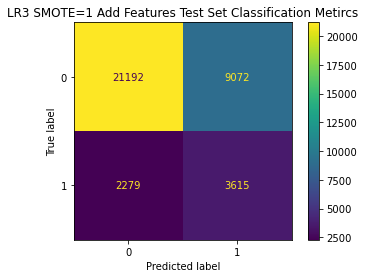

              precision    recall  f1-score   support

           0       0.90      0.70      0.79     30264
           1       0.28      0.61      0.39      5894

    accuracy                           0.69     36158
   macro avg       0.59      0.66      0.59     36158
weighted avg       0.80      0.69      0.72     36158



In [39]:
plot_confusion_matrix(lr3,X0_test_sc,y0_test)
plt.title('LR3 SMOTE=1 Add Features Test Set Classification Metircs')
plt.show()
print(classification_report(y0_test,lr3.predict(X0_test_sc)))

## LR4 Regularization Tuning C

In [40]:
from sklearn.model_selection import GridSearchCV
params={'C':[1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,0.1,1,10,1e+2,1e+3,1e+4]}
clf=GridSearchCV(lr2,params,scoring='recall')
clf.fit(X_train_resam,y_train_resam)
clf.cv_results_

{'mean_fit_time': array([0.21748724, 0.22364492, 0.24695978, 0.76110301, 0.63398438,
        1.59272113, 1.80782752, 1.85872173, 1.91977229, 1.97717395,
        2.14393044, 1.73376665, 2.70289321]),
 'std_fit_time': array([0.07950516, 0.00533825, 0.12366178, 0.29362407, 0.05667613,
        0.78098165, 0.09445218, 0.15093231, 0.17345464, 0.40723082,
        0.40212657, 0.75921458, 0.41878284]),
 'mean_score_time': array([0.01491723, 0.02843161, 0.01675658, 0.01778855, 0.02095137,
        0.02926335, 0.01675234, 0.02525353, 0.02294512, 0.01788988,
        0.03896947, 0.04085059, 0.04947505]),
 'std_score_time': array([0.00291442, 0.01962103, 0.00118495, 0.00432513, 0.00448295,
        0.02066576, 0.00201115, 0.01419356, 0.01188834, 0.00248147,
        0.0310895 , 0.04595031, 0.04282179]),
 'param_C': masked_array(data=[1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1,
                    1, 10, 100.0, 1000.0, 10000.0],
              mask=[False, False, False, False, False, False, Fal

In [41]:
clf.best_params_

{'C': 1e-06}

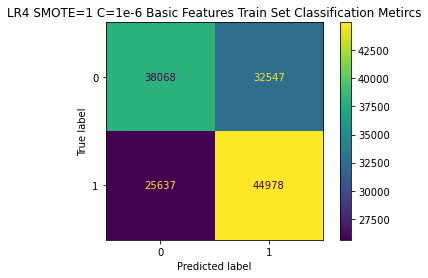

              precision    recall  f1-score   support

           0       0.60      0.54      0.57     70615
           1       0.58      0.64      0.61     70615

    accuracy                           0.59    141230
   macro avg       0.59      0.59      0.59    141230
weighted avg       0.59      0.59      0.59    141230



In [42]:
lr4=LogisticRegression(C=1e-6,random_state=42)
lr4.fit(X_train_resam,y_train_resam)
plot_confusion_matrix(lr4,X_train_resam,y_train_resam)
plt.title('LR4 SMOTE=1 C=1e-6 Basic Features Train Set Classification Metircs')
plt.show()
print(classification_report(y_train_resam,lr4.predict(X_train_resam)))

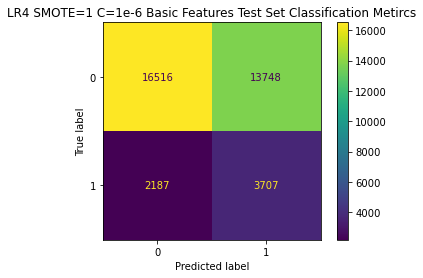

              precision    recall  f1-score   support

           0       0.88      0.55      0.67     30264
           1       0.21      0.63      0.32      5894

    accuracy                           0.56     36158
   macro avg       0.55      0.59      0.50     36158
weighted avg       0.77      0.56      0.62     36158



In [43]:
plot_confusion_matrix(lr4,X_test_sc,y_test)
plt.title('LR4 SMOTE=1 C=1e-6 Basic Features Test Set Classification Metircs')
plt.show()
print(classification_report(y_test,lr4.predict(X_test_sc)))

In [44]:
clf1=GridSearchCV(lr3,params,scoring='recall')
clf1.fit(X0_train_resam,y0_train_resam)
clf1.cv_results_

{'mean_fit_time': array([0.37986493, 0.39337811, 0.80734301, 0.84764128, 1.26776762,
        1.2572515 , 3.2295073 , 3.01294866, 1.82372494, 1.86124997,
        2.69891591, 6.25752978, 3.21919737]),
 'std_fit_time': array([0.14962608, 0.09454726, 0.05471779, 0.07898627, 0.20388937,
        0.85650238, 2.04435467, 1.20431513, 0.13718336, 0.65572829,
        1.8213978 , 1.26202353, 1.91871143]),
 'mean_score_time': array([0.02806902, 0.02609396, 0.03949447, 0.04041023, 0.0371119 ,
        0.01844449, 0.03434157, 0.0210762 , 0.01933374, 0.0183713 ,
        0.03267365, 0.0170301 , 0.01983004]),
 'std_score_time': array([0.01363038, 0.01535703, 0.03371723, 0.03275012, 0.03426357,
        0.00083543, 0.03267016, 0.00222775, 0.00158082, 0.00047017,
        0.02349534, 0.00123047, 0.00251189]),
 'param_C': masked_array(data=[1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1,
                    1, 10, 100.0, 1000.0, 10000.0],
              mask=[False, False, False, False, False, False, Fal

In [45]:
clf1.best_params_

{'C': 1e-06}

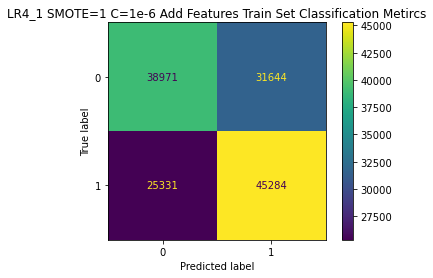

              precision    recall  f1-score   support

           0       0.61      0.55      0.58     70615
           1       0.59      0.64      0.61     70615

    accuracy                           0.60    141230
   macro avg       0.60      0.60      0.60    141230
weighted avg       0.60      0.60      0.60    141230



In [46]:
lr4_1=LogisticRegression(C=1e-6,random_state=42)
lr4_1.fit(X0_train_resam,y0_train_resam)
plot_confusion_matrix(lr4_1,X0_train_resam,y0_train_resam)
plt.title('LR4_1 SMOTE=1 C=1e-6 Add Features Train Set Classification Metircs')
plt.show()
print(classification_report(y0_train_resam,lr4_1.predict(X0_train_resam)))

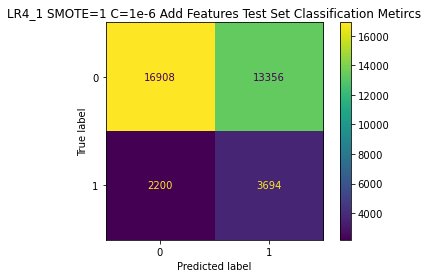

              precision    recall  f1-score   support

           0       0.88      0.56      0.68     30264
           1       0.22      0.63      0.32      5894

    accuracy                           0.57     36158
   macro avg       0.55      0.59      0.50     36158
weighted avg       0.78      0.57      0.63     36158



In [47]:
plot_confusion_matrix(lr4_1,X0_test_sc,y0_test)
plt.title('LR4_1 SMOTE=1 C=1e-6 Add Features Test Set Classification Metircs')
plt.show()
print(classification_report(y0_test,lr4_1.predict(X0_test_sc)))

In [ ]:
f, ax=plt.subplots()
plot_roc_curve(lr,X_test_sc,y_test,ax=ax,label=f"baseline AUC {roc_auc_score(y_test,lr.predict_proba(X_test_sc)[:,1]):.2f}")
plot_roc_curve(lr1,X_test_sc,y_test,ax=ax,label=f"lr1 AUC {roc_auc_score(y_test,lr1.predict_proba(X_test_sc)[:,1]):.2f}")
plot_roc_curve(lr2,X_test_sc,y_test,ax=ax,label=f"lr2 AUC {roc_auc_score(y_test,lr2.predict_proba(X_test_sc)[:,1]):.2f}")
plot_roc_curve(lr3,X_test_sc,y_test,ax=ax,label=f"lr3 AUC {roc_auc_score(y_test,lr3.predict_proba(X_test_sc)[:,1]):.2f}")
plot_roc_curve(lr3_1,X_test_sc,y_test,ax=ax,label=f"lr3_1 AUC {roc_auc_score(y_test,lr3_1.predict_proba(X_test_sc)[:,1]):.2f}")

In [48]:
def cross_val (X_train, y_train, C, num_split=10):
    X_train = X_train.values
    y_train = y_train.values
    
    score_train_list = []
    score_val_list = []
    
    smote=SMOTE(sampling_strategy=1)
    X_train_resam,y_train_resam=smote.fit_resample(X_train,y_train)
    for train_index, valid_index in KFold(n_splits = num_split).split(X_train_resam):


        # train and validation splitting 
        X_train_fold, X_val_fold = X_train_resam[train_index], X_train_resam[valid_index]
        y_train_fold, y_val_fold = y_train_resam[train_index], y_train_resam[valid_index]

        #create/fit the Standard scaler on the train fold
        scaler = StandardScaler()
        X_tf_num_sc = scaler.fit_transform(X_train_fold[:,0:7])
        X_tf_sc=np.concatenate((X_tf_num_sc,X_train_fold[:,7:]),axis=1)
        # transform validation fold
        X_vld_num_sc = scaler.transform(X_val_fold[:,0:7])
        X_vld_sc = np.concatenate((X_vld_num_sc,X_val_fold[:,7:]),axis=1)
        # create/fit logistic regression
        logreg = LogisticRegression(C = C)
        logreg.fit(X_tf_sc, y_train_fold)
        
        # now how did we do in recall score?
        recall_train = recall_score(y_train_fold,logreg.predict(X_tf_sc))
        recall_val = recall_score(y_val_fold,logreg.predict(X_vld_sc))
        score_val_list.append(recall_train)
        score_train_list.append(recall_val)
    
    return {'C': C, 'train': np.mean(score_train_list), 'validation': np.mean(score_val_list)}

In [51]:
def cross_validate (X_train, y_train, C, num_split=10):
    X_train = X_train.values
    y_train = y_train.values
    
    score_train_list = []
    score_val_list = []
    
    for train_index, valid_index in KFold(n_splits = num_split).split(X_train):


        # train and validation splitting 
        X_train_fold, X_val_fold = X_train[train_index], X_train[valid_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[valid_index]

        #create/fit the Standard scaler on the train fold
        scaler = StandardScaler()
        X_tf_num_sc = scaler.fit_transform(X_train_fold[:,0:7])
        X_tf_sc=np.concatenate((X_tf_num_sc,X_train_fold[:,7:]),axis=1)
        # transform validation fold
        X_vld_num_sc = scaler.transform(X_val_fold[:,0:7])
        X_vld_sc = np.concatenate((X_vld_num_sc,X_val_fold[:,7:]),axis=1)
        # create/fit logistic regression
        logreg = LogisticRegression(C = C)
        logreg.fit(X_tf_sc, y_train_fold)
        
        # now how did we do in recall score?
        recall_train = recall_score(y_train_fold,logreg.predict(X_tf_sc))
        recall_val = recall_score(y_val_fold,logreg.predict(X_vld_sc))
        score_val_list.append(recall_train)
        score_train_list.append(recall_val)
    
    return {'C': C, 'train': np.mean(score_train_list), 'validation': np.mean(score_val_list)}

In [52]:
# empty dataframe
crossval_df = pd.DataFrame(columns = ['C', 'train', 'validation'])
# append results for each value of C
for C in [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,0.1,1,10,1e+2,1e+3,1e+4]:
    crossval_df = crossval_df.append(cross_val(X_train, y_train, C, 5),ignore_index=True)
crossval_df

,C,train,validation
0,1.000000e-08,0.600000,0.600000
1,1.000000e-07,0.600000,0.600000
2,1.000000e-06,0.549996,0.570305
3,1.000000e-05,0.526165,0.552376
4,1.000000e-04,0.554179,0.575833
5,1.000000e-03,0.591313,0.617859
6,1.000000e-02,0.564004,0.595517
7,1.000000e-01,0.568398,0.598036
8,1.000000e+00,0.563497,0.595861
9,1.000000e+01,0.555467,0.589140


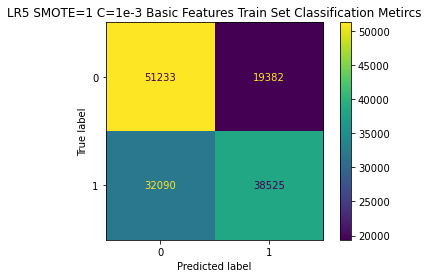

              precision    recall  f1-score   support

           0       0.61      0.73      0.67     70615
           1       0.67      0.55      0.60     70615

    accuracy                           0.64    141230
   macro avg       0.64      0.64      0.63    141230
weighted avg       0.64      0.64      0.63    141230



In [53]:
lr5=LogisticRegression(C=1e-3,random_state=42)
lr5.fit(X_train_resam,y_train_resam)
plot_confusion_matrix(lr5,X_train_resam,y_train_resam)
plt.title('LR5 SMOTE=1 C=1e-3 Basic Features Train Set Classification Metircs')
plt.show()
print(classification_report(y_train_resam,lr5.predict(X_train_resam)))

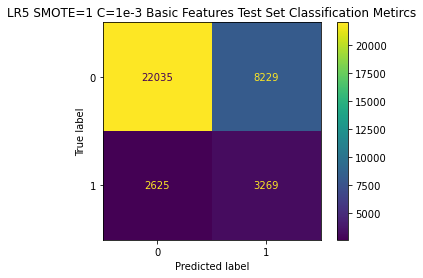

              precision    recall  f1-score   support

           0       0.89      0.73      0.80     30264
           1       0.28      0.55      0.38      5894

    accuracy                           0.70     36158
   macro avg       0.59      0.64      0.59     36158
weighted avg       0.79      0.70      0.73     36158



In [54]:
plot_confusion_matrix(lr5,X_test_sc,y_test)
plt.title('LR5 SMOTE=1 C=1e-3 Basic Features Test Set Classification Metircs')
plt.show()
print(classification_report(y_test,lr5.predict(X_test_sc)))

In [55]:
print('LR2 Model Co-efficients')
for index in range(0,9):
    print(X_train.columns[index],lr2.coef_[0,index])
print('----------------------')
print('LR4 Model Co-efficients')
for index in range(0,9):
    print(X_train.columns[index],lr4.coef_[0,index])

LR2 Model Co-efficients
loan_amount -0.1874251686510712
term -0.04788751511380606
property_value 0.3166809850010293
income -0.24142636857201144
Credit_Score 0.01777606596676475
LTV 0.2965665774498719
dtir1 0.10892818212081734
x0_nob/c -0.568944286078071
x1_not_neg -0.9875768720135238
----------------------
LR4 Model Co-efficients
loan_amount -0.003102466978194615
term 0.0012055320512523086
property_value -0.003690885204641488
income -0.006964701522392047
Credit_Score 0.00026386237465643464
LTV 0.008169156959256466
dtir1 0.007068506420571315
x0_nob/c -0.003511109975774765
x1_not_neg -0.003524361607402307


In [56]:
print('LR3 Model Co-efficients')
for index in range(0,32):
    print(X0_train.columns[index],lr3.coef_[0,index])
print('----------------------')
print('LR4_1 Model Co-efficients')
for index in range(0,32):
    print(X0_train.columns[index],lr4_1.coef_[0,index])

LR3 Model Co-efficients
loan_amount -0.26278163357563705
term -0.02467218471772174
property_value 0.3797659180071386
income -0.29638637150165126
Credit_Score 0.02323390377303115
LTV 0.5251959682984667
dtir1 0.10307560000076794
x0_nob/c 0.868732667047747
x1_not_neg -0.8823869363113465
x2_not_lpsm -2.7092684776490024
x3_not_int 0.041532605659981396
x0_ncf 0.7623136934593026
x1_pre -0.38711060208318454
x2_type2 1.3481128320993905
x2_type3 -0.3370415707582967
x3_p2 1.051290941193696
x3_p3 0.4193044455985052
x3_p4 0.3422361953786148
x4_l2 -0.02435565427526881
x5_opc -0.2169806958126531
x6_pr -0.5418117862196516
x6_sr -0.1992615785074778
x7_2U 0.45433075942638224
x7_3U 0.6004667847839876
x7_4U -0.16421142888955007
x8_35-44 -0.038117604455239595
x8_45-54 0.21449163033943444
x8_55-64 0.3459349735227633
x8_65-74 0.33838052301851057
x8_<25 0.02775802574756008
x8_>74 0.39848956338802266
x9_North-East 0.07341140825439522
----------------------
LR4_1 Model Co-efficients
loan_amount -0.0036111536952

# Decision Trees

In [58]:
tree=DecisionTreeClassifier(random_state=42)

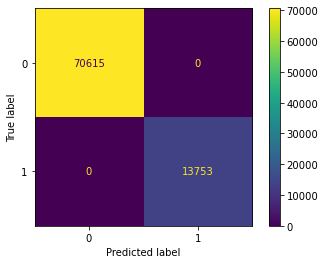

In [59]:
tree.fit(X_train_sc,y_train)
plot_confusion_matrix(tree,X_train_sc,y_train)

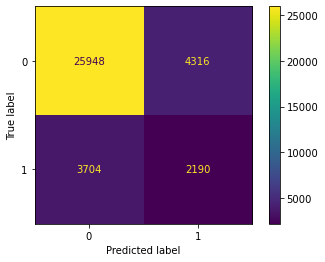

In [60]:
plot_confusion_matrix(tree,X_test_sc,y_test)

In [61]:
tree.get_depth()

51

In [65]:
tree_params={'max_depth':[50,47,45,43,40,35,30,25,20,15,10,7,5,3]}
clf3=GridSearchCV(tree,tree_params,scoring='recall')
clf3.fit(X_train_sc,y_train)
clf3.cv_results_

{'mean_fit_time': array([0.75337877, 0.7572382 , 0.6934207 , 0.72034574, 0.74154444,
        0.68380013, 0.73155193, 0.6782104 , 0.5451726 , 0.43862848,
        0.27992702, 0.29350519, 0.17482042, 0.09084897]),
 'std_fit_time': array([0.03106782, 0.10403268, 0.0279632 , 0.02915002, 0.04463435,
        0.07336642, 0.1009933 , 0.1231393 , 0.02783303, 0.04286187,
        0.021148  , 0.16490117, 0.05423203, 0.00599766]),
 'mean_score_time': array([0.0142343 , 0.01376438, 0.01405315, 0.01273904, 0.01373062,
        0.012637  , 0.01504254, 0.01378465, 0.01061502, 0.00946264,
        0.00841155, 0.00935926, 0.00772066, 0.00711694]),
 'std_score_time': array([0.00307138, 0.00071807, 0.00099352, 0.00100426, 0.00110495,
        0.00083895, 0.00244122, 0.00343537, 0.00098361, 0.00052945,
        0.00089781, 0.00221464, 0.00075951, 0.00036193]),
 'param_max_depth': masked_array(data=[50, 47, 45, 43, 40, 35, 30, 25, 20, 15, 10, 7, 5, 3],
              mask=[False, False, False, False, False, False,

In [66]:
clf3.best_params_

{'max_depth': 43}

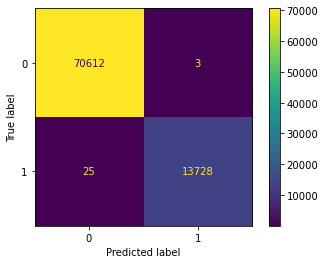

In [67]:
tree1=DecisionTreeClassifier(max_depth=43,random_state=42)
tree1.fit(X_train_sc,y_train)
plot_confusion_matrix(tree1,X_train_sc,y_train)

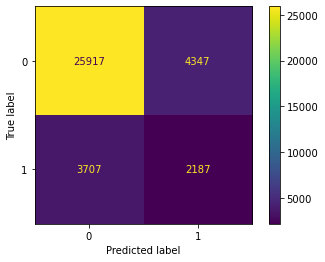

In [68]:
plot_confusion_matrix(tree1,X_test_sc,y_test)

In [69]:
for ratio in np.linspace(0.2,1,9):
    smote=SMOTE(sampling_strategy=ratio)
    X_train_resam,y_train_resam=smote.fit_resample(X_train_sc,y_train)
    tree=DecisionTreeClassifier(random_state=42)
    tree.fit(X_train_resam,y_train_resam)
    print(f"ratio {ratio:.2f} train recall score {recall_score(y_train_resam,tree.predict(X_train_resam)):.2f} test recall score {recall_score(y_test,tree.predict(X_test_sc)):.2f}")

ratio 0.20 train recall score 1.00 test recall score 0.37
ratio 0.30 train recall score 1.00 test recall score 0.39
ratio 0.40 train recall score 1.00 test recall score 0.40
ratio 0.50 train recall score 1.00 test recall score 0.39
ratio 0.60 train recall score 1.00 test recall score 0.40
ratio 0.70 train recall score 1.00 test recall score 0.40
ratio 0.80 train recall score 1.00 test recall score 0.40
ratio 0.90 train recall score 1.00 test recall score 0.40
ratio 1.00 train recall score 1.00 test recall score 0.40


even resampling still looks appropriate, so will keep implementing X_train_resam,y_train_resam as defined earlier

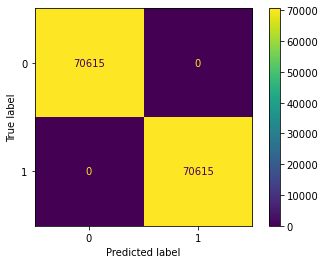

In [70]:
tree2=DecisionTreeClassifier(random_state=42)
tree2.fit(X_train_resam,y_train_resam)
plot_confusion_matrix(tree2,X_train_resam,y_train_resam)

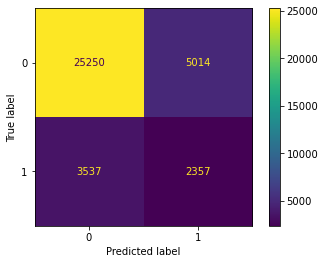

In [71]:
plot_confusion_matrix(tree2,X_test_sc,y_test)

In [73]:
tree2.get_depth()

70

In [75]:
tree_params={'max_depth':[65,63,60,55,50,45,40,35,30,25,20,18,15,10,7,5,4,3]}
clf4=GridSearchCV(tree2,tree_params,scoring='recall')
clf4.fit(X_train_resam,y_train_resam)
clf4.cv_results_

{'mean_fit_time': array([1.65700083, 1.77019897, 1.68334002, 1.72169361, 1.59644413,
        2.13018451, 2.09261622, 1.60279031, 1.81324596, 1.83936725,
        1.72482271, 1.60903416, 1.29814067, 0.93819027, 0.70679345,
        0.57261648, 0.45302033, 0.34575334]),
 'std_fit_time': array([0.11776952, 0.23210042, 0.10445246, 0.305479  , 0.2043444 ,
        0.23489025, 0.19242395, 0.28696941, 0.19325307, 0.2100015 ,
        0.17855861, 0.08465414, 0.18634193, 0.09253997, 0.12569034,
        0.07328164, 0.10574426, 0.02216408]),
 'mean_score_time': array([0.02239933, 0.02147222, 0.0223165 , 0.02041082, 0.02216191,
        0.02528205, 0.02952118, 0.01816258, 0.02391672, 0.02703133,
        0.02294979, 0.02405362, 0.02039452, 0.01817312, 0.02019119,
        0.02737379, 0.02482061, 0.02144341]),
 'std_score_time': array([0.00494387, 0.00517541, 0.00477493, 0.00155971, 0.00647629,
        0.00313313, 0.00539207, 0.00143423, 0.00481902, 0.00585199,
        0.00466749, 0.00537582, 0.00551373, 

In [77]:
clf4.best_estimator_

DecisionTreeClassifier(max_depth=63, random_state=42)

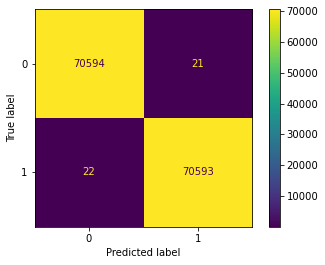

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     70615
           1       1.00      1.00      1.00     70615

    accuracy                           1.00    141230
   macro avg       1.00      1.00      1.00    141230
weighted avg       1.00      1.00      1.00    141230



In [79]:
tree3=DecisionTreeClassifier(max_depth=63,random_state=42)
tree3.fit(X_train_resam,y_train_resam)
plot_confusion_matrix(tree3,X_train_resam,y_train_resam)
plt.show()
print(classification_report(y_train_resam,tree3.predict(X_train_resam)))

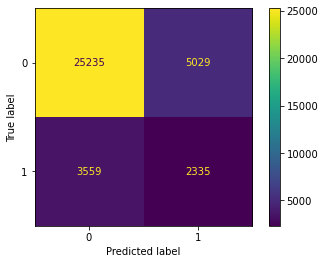

In [80]:
plot_confusion_matrix(tree3,X_test_sc,y_test)

In [82]:
tree_params={'max_depth':[20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3]}
clf5=GridSearchCV(tree2,tree_params,scoring='recall')
clf5.fit(X_train_resam,y_train_resam)
clf5.cv_results_

{'mean_fit_time': array([1.19965754, 1.45953698, 1.2723897 , 1.43938861, 1.43370433,
        1.24830885, 1.3091372 , 0.97837472, 0.84374928, 1.06361127,
        0.95479708, 0.9144927 , 0.68653383, 0.59497232, 0.62173033,
        0.6264689 , 0.4753829 , 0.31258492]),
 'std_fit_time': array([0.09390219, 0.21342687, 0.20366248, 0.07069384, 0.23793977,
        0.14848564, 0.24455323, 0.10944083, 0.04576861, 0.07359677,
        0.16543849, 0.14869763, 0.13173907, 0.03374032, 0.11635092,
        0.12388259, 0.06968155, 0.05412005]),
 'mean_score_time': array([0.01566114, 0.02004523, 0.01830926, 0.02321777, 0.02112379,
        0.02172246, 0.01865005, 0.01559324, 0.0169189 , 0.02009306,
        0.02444878, 0.01951284, 0.01658449, 0.01684551, 0.01740465,
        0.02083211, 0.01940918, 0.01668472]),
 'std_score_time': array([0.00085748, 0.00478936, 0.00413928, 0.00398596, 0.00410492,
        0.0031694 , 0.00524343, 0.0030226 , 0.0031809 , 0.00472952,
        0.00404963, 0.00456821, 0.00372123, 

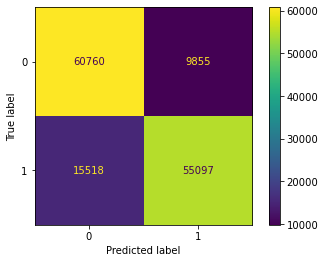

              precision    recall  f1-score   support

           0       0.80      0.86      0.83     70615
           1       0.85      0.78      0.81     70615

    accuracy                           0.82    141230
   macro avg       0.82      0.82      0.82    141230
weighted avg       0.82      0.82      0.82    141230



In [83]:
tree4=DecisionTreeClassifier(max_depth=19,random_state=42)
tree4.fit(X_train_resam,y_train_resam)
plot_confusion_matrix(tree4,X_train_resam,y_train_resam)
plt.show()
print(classification_report(y_train_resam,tree4.predict(X_train_resam)))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85     30264
           1       0.32      0.46      0.38      5894

    accuracy                           0.75     36158
   macro avg       0.60      0.64      0.61     36158
weighted avg       0.79      0.75      0.77     36158



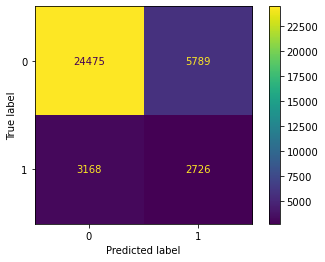

In [91]:
plot_confusion_matrix(tree4,X_test_sc,y_test)
print(classification_report(y_test,tree4.predict(X_test_sc)))

In [90]:
tree4.feature_importances_
print('Tree4 Model Feature Importances')
print('----------------------')
for index in range(0,10):
    print(X_train.columns[index],tree5.feature_importances_[index])

Tree4 Model Feature Importances
----------------------
loan_amount 0.004363440314210003
term 0.0
property_value 0.0
income 0.17075899829925045
Credit_Score 0.0
LTV 0.021575670478439078
dtir1 0.4842881679862326
x0_nob/c 0.02422436724617863
x1_not_neg 0.1691048362426608
x2_not_lpsm 0.12568451943302855


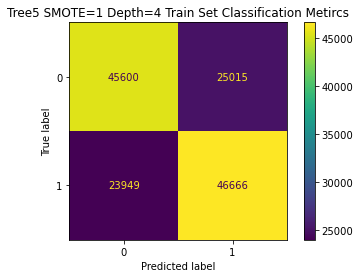

              precision    recall  f1-score   support

           0       0.66      0.65      0.65     70615
           1       0.65      0.66      0.66     70615

    accuracy                           0.65    141230
   macro avg       0.65      0.65      0.65    141230
weighted avg       0.65      0.65      0.65    141230



In [93]:
tree5=DecisionTreeClassifier(max_depth=4,random_state=42)
tree5.fit(X_train_resam,y_train_resam)
plot_confusion_matrix(tree5,X_train_resam,y_train_resam)
plt.title('Tree5 SMOTE=1 Depth=4 Train Set Classification Metircs')
plt.show()
print(classification_report(y_train_resam,tree5.predict(X_train_resam)))

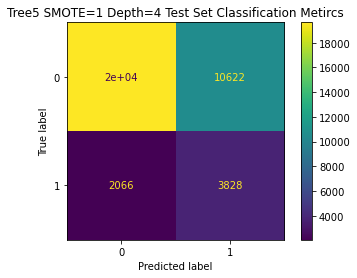

              precision    recall  f1-score   support

           0       0.90      0.65      0.76     30264
           1       0.26      0.65      0.38      5894

    accuracy                           0.65     36158
   macro avg       0.58      0.65      0.57     36158
weighted avg       0.80      0.65      0.69     36158



In [94]:
plot_confusion_matrix(tree5,X_test_sc,y_test)
plt.title('Tree5 SMOTE=1 Depth=4 Test Set Classification Metircs')
plt.show()
print(classification_report(y_test,tree5.predict(X_test_sc)))

In [95]:
tree5.feature_importances_
print('Tree5 Model Feature Importances')
print('----------------------')
for index in range(0,10):
    print(X_train.columns[index],tree5.feature_importances_[index])

Tree5 Model Feature Importances
----------------------
loan_amount 0.004363440314210003
term 0.0
property_value 0.0
income 0.17075899829925045
Credit_Score 0.0
LTV 0.021575670478439078
dtir1 0.4842881679862326
x0_nob/c 0.02422436724617863
x1_not_neg 0.1691048362426608
x2_not_lpsm 0.12568451943302855


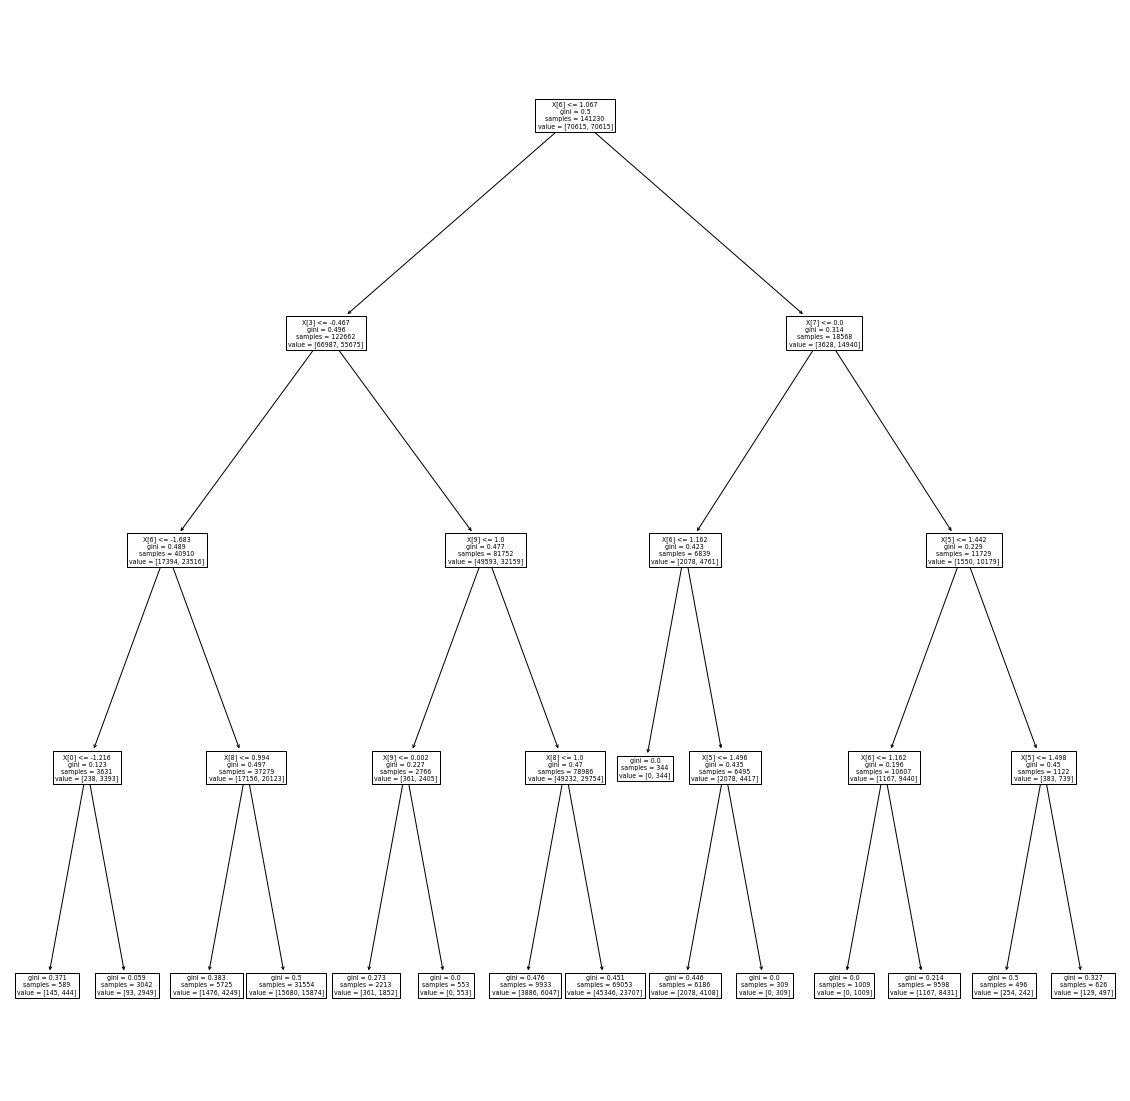

In [96]:
f,ax=plt.subplots(figsize=(20,20))
plot_tree(tree5,ax=ax)
plt.show()